In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
from autograd import grad
import cca

12.376047703061545
6.123154342555665


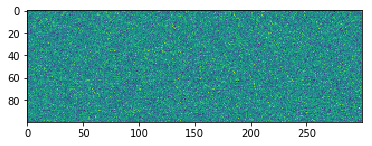

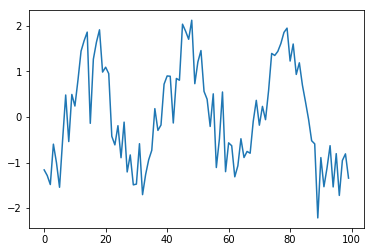

In [4]:
N = 100
len_X = 1000
latent_dim = 1
T = 20

E = scipy.stats.ortho_group.rvs(N)[:, :latent_dim]
dynamics = np.zeros((len_X, latent_dim))
t = np.arange(len_X)*0.2
for i in range(latent_dim):
    a, b = np.random.normal(0, 1, (2,))
    dynamics[:, i] = a*np.sin(t) + b*np.cos(t)

original_pi = cca.calc_pi(dynamics, T)
print(original_pi)

original_pi = cca.calc_pi(dynamics + np.random.normal(0, 0.5, dynamics.shape), T)
print(original_pi)

X = np.dot(dynamics, E.T)
X = X + np.random.normal(0, 0.5, X.shape)

plt.imshow(X[:3*N, :].T)
plt.show()

plt.plot(np.dot(X, E[:, :latent_dim])[:100])
plt.show()

In [29]:
loss = cca.build_loss(X, T, latent_dim, kron=False)
grad_loss = grad(loss)


opt_pi_vals = []
num_trials = 5

for trial_idx in range(num_trials):
    v_init = np.random.normal(0, 1, (latent_dim, N))
    v_init = v_init / np.sqrt(np.sum(v_init**2, axis=1, keepdims=True))

    opt_result = scipy.optimize.minimize(loss, v_init.flatten(), method='BFGS', jac=grad_loss, options={"disp":True})
    v_opt_flat = opt_result["x"]
    opt_pi = -loss(v_opt_flat)
    print(opt_pi)
    opt_pi_vals.append(opt_pi)

    #v_opt = v_opt_flat.reshape((latent_dim, N))
    #v_opt = v_opt / np.sqrt(np.sum(v_opt**2, axis=1, keepdims=True))



List loss!
         Current function value: -9.313218
         Iterations: 4
         Function evaluations: 56
         Gradient evaluations: 49
9.313217823801914
         Current function value: -12.535242
         Iterations: 4
         Function evaluations: 55
         Gradient evaluations: 47
12.535242203443438
         Current function value: -11.167056
         Iterations: 5
         Function evaluations: 63
         Gradient evaluations: 56
11.167056210044265
         Current function value: -12.309833
         Iterations: 4
         Function evaluations: 61
         Gradient evaluations: 52
12.309832721370363
         Current function value: -9.106136
         Iterations: 3
         Function evaluations: 62
         Gradient evaluations: 56
9.106135761969128


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 5.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

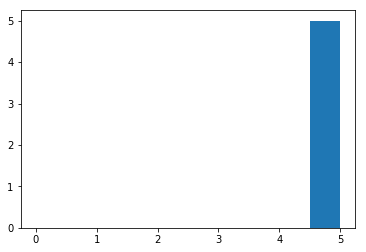

In [27]:
plt.hist(opt_pi_vals, range=(0, 5))